# Approach (Please upload this file to google colab - This was made Sept 2022 prior to GPT 4)
High level is that I suggest using bert with lemmatization trained on combination labels.

1.   Data was loaded into the notebook
2.   Data exploration to determine (imbalance, correlation, duplications, etc.)
3.   Feature engineering to improve performance
4.   Data spliting Training/dev/test
5.   Model design considerations after understanding status of data
6.   Train baseline model (logistic regression)
7.   Run 7 additional expirements to determine best option
8.   Implementation BERT on new data
9.   If no GPU implement logistic regression on new data

Detailed takeaways are below labeled by each step.

# Model Expirement results
Model | output | F1 | Accuracy | Percision | Recall
- | - | - | - | - | -
Logistic (basline)       | combined | 0.75 | 0.78 | 0.61 | 0.78
Logistic + Lemmas        | combined | 0.78 | 0.80 | 0.63 | 0.80
Logistic + Lemmas        | coarse   | 0.85 | 0.85 | 0.88 | 0.85
Logistic + Lemmas        | fine     | 0.76 | 0.77 | 0.69 | 0.77
BERT                     | combined | 0.91 | 0.91 | 0.81 | 0.91
Design 1: BERT + Lemmas  | combined | 0.91 | 0.91 | 0.85 | 0.91
Design 2: BERT + Lemmas  | coarse   | 0.94 | 0.94 | 0.94 | 0.94
Design 2: BERT + Lemmas  | fine     | 0.91 | 0.91 | 0.85 | 0.91

(Note F1 score is weighted here to take into account class imbalances that is why it is )

## Analyzing the expirement results

*   BERT models out performs tradditional machine learning methods
*   Feature engineering/data augmentation improves performance
*   Due to imbalance issues of the data it is suggested to believe these scores are lower than presented

## Suggested Method: Design 1 - BERT + Lemmas with combined labels
Detailed description of designs are in STEP 5. Read that section to understand what design 1,2 mean.

### Advantages of suggestion:
*   Only need to implement 1 model
*   Better than human level performance (human level which is around 89 F1 Score[link text](https://rajpurkar.github.io/SQuAD-explorer/))
*   Out performs traditional methods
*   Because it is pre-trained model it is more equipped to handle unseen situations

### Disadvantages:
*   Requires GPU to train
*   Longer training time than traditional methods
*   Not as great performance as design 2 for coarse labels
*   Could be expensive due to GPU and training requirements

### Why design 1 over design 2

* Overall design 1 is superior because it has similiar levels of performance and the implementation costs are halved


The best performing model is BERT + Lemmas with coarse and fine labels (design 2). However the performance is marginal compared to design 1 bert methods with imbalanced data there will be variation with model performance so the marginal gains may not be actualized. There is no performance difference between design 2 fine label model and design 1. Yet design 2 requires training an additional model.



## Potential improvements
*   Add more data augmentation and feature engineering
>*   Parts of speech tagging (POS)
>*   Named Entity Recognition
*  Find pre-trained BERT model that is specific to question intent classification at the sentence level
*   Fine tune parameters in BERT model
*   Test other traditional machine learning models (tree based methods, non-linear methods) if cost is a constraint

# STEP 1: Data import and DataFrame creation

After importing/downloading file to working directory will need to read the file into script. I needed to use encoding ISO-8859-1 to solve the problem

In [ ]:
import gzip
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

clear_output()

In [ ]:
import gzip
with gzip.open('training.data.gz', mode ='rt',encoding = "ISO-8859-1") as f:
  file_content = f.read()

The data is processed into 4 columns:

*   **question**: The question text of the dataset
*   **coarse**: The 4 letter token in left of the ":" in the original label
*   **fine**: The token to the right of the ":" in the original label
*   **combined**: The original label without splitting on the ":"
*   **[coarse, fine, combined]** are considered labels in this dataframe

Original labels were presented in "DESC:manner" format. I split them on the ":".

In [ ]:
input_data = []

for row in file_content.split('\n'):
  input_row = {}
  try:
    labels , question = row.split(' ', 1)
    label_1 , label_2 = labels.split(':')
    input_row['coarse'] = label_1
    input_row['fine'] = label_2
    input_row['combined'] = labels
    input_row['question'] = question
    input_data.append(input_row)
  except:
    print(row)
    #there is an extra empty row at the end of the data file


df_training = pd.DataFrame(input_data)

df_training.head()

,coarse,fine,combined,question
0,DESC,manner,DESC:manner,How did serfdom develop in and then leave Russ...
1,ENTY,cremat,ENTY:cremat,What films featured the character Popeye Doyle ?
2,DESC,manner,DESC:manner,How can I find a list of celebrities ' real na...
3,ENTY,animal,ENTY:animal,What fowl grabs the spotlight after the Chines...
4,ABBR,exp,ABBR:exp,What is the full form of .com ?


# STEP 2: Data exploration
Key take aways:


*   Duplications were present and removed from dataset
*   Dataset has heavy imbalances which requires special attention during train/dev/test split and model evaluation

*   Description of the labels
>1.   coarse labels - 6 unique classes
>2.   fine labels - 47 unique classes
>3.   combined labels - 50 unique classes

*   coarse labels and fine labels are heavily correlated



## Duplications and Unique classes

In [ ]:
print(f"There are {df_training.shape[0]} rows in the dataset.")
total_duplicate_q = sum(df_training["question"].duplicated())
print(f"There are {total_duplicate_q} duplicate questions.")
print()
print('Dropping duplicates')
df_training = df_training[~df_training["question"].duplicated()]
print(f"There are {df_training.shape[0]} rows in the unique data points in the clean data.")
print()
print(f"For coarse labels there are: {df_training.coarse.nunique()} unique classes")
print(f"For fine labels there are: {df_training.fine.nunique()} unique classes")
print(f"For combined labels there are: {df_training.combined.nunique()} unique classes")

There are 15452 rows in the dataset.
There are 10071 duplicate questions.

Dropping duplicates
There are 5381 rows in the unique data points in the clean data.

For coarse labels there are: 6 unique classes
For fine labels there are: 47 unique classes
For combined labels there are: 50 unique classes


## Dataset is imbalanced

Key take aways:


*   Imbalance in classes accross all 3 labels [coarse, fine, combined]
*   [coarse, fine] labels have significant imbalances
*   Caution against using accuracy as only metric when evaluating and designing models due to imbalance.


We can see from the plot below that the ABBR class has significant less samples than other class in coarse labels showing that the dataset is imbalanced. Similarly there are a lot more classes in fine labels show even more imbalance within the classes. We see that combined label also has imbalance within the data set.

Due to the imbalanced dataset evaluation an F1 score and other metrics will be necessary to capture errors in the minority classes. We cannot use a simple accuracy measure.

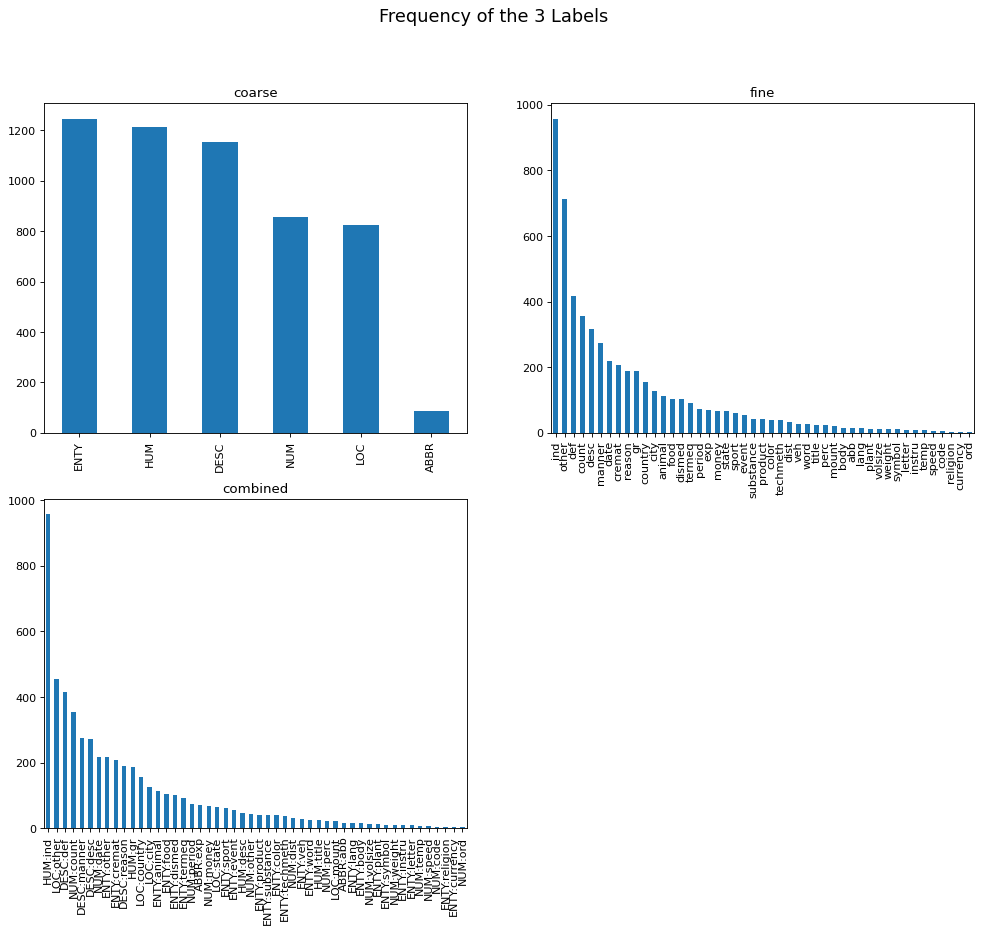

In [ ]:
fig = plt.figure(figsize=(15, 12), dpi=80)
ax = fig.add_subplot(221)
plot_coarse_bar = df_training.coarse.value_counts().plot(kind='bar',subplots=True)
fig.suptitle('Frequency of the 3 Labels', fontsize=16)
ax = fig.add_subplot(222)
plot_fine_bar = df_training.fine.value_counts().plot(kind='bar',subplots=True)
ax = fig.add_subplot(223)
plot_combined_bar = df_training.combined.value_counts().plot(kind='bar',subplots=True)
plt.show()

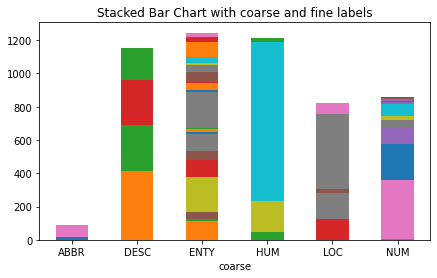

In [ ]:
# Creating crosstab
crosstb = pd.crosstab(df_training.coarse, df_training.fine)

pl = crosstb.plot(kind="bar", rot=0, stacked = True, title="Stacked Bar Chart with coarse and fine labels").legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0).remove()



In [ ]:
#run if interested in seeing specifid numbers
print(df_training.coarse.value_counts())
print(df_training.fine.value_counts())
print(df_training.combined.value_counts())

ENTY    1245
HUM     1215
DESC    1153
NUM      858
LOC      824
ABBR      86
Name: coarse, dtype: int64
ind          956
other        714
def          416
count        355
desc         318
manner       275
date         218
cremat       207
reason       190
gr           188
country      155
city         127
animal       112
food         103
dismed       102
termeq        92
period        74
exp           70
money         67
state         66
sport         62
event         55
substance     41
product       41
color         40
techmeth      38
dist          32
veh           27
word          26
title         25
perc          23
mount         21
body          16
abb           16
lang          16
plant         13
volsize       13
weight        11
symbol        11
letter         9
instru         9
temp           8
speed          7
code           5
religion       4
currency       4
ord            3
Name: fine, dtype: int64
HUM:ind           956
LOC:other         455
DESC:def          416
NUM:c

## Correlation of Coarse and Fine labels

Looking at the plots, Cramer's V, and Chi Squared Goodness of fit reveals that the two labels are correlated.

Cramer's V: 0.95 Chi Squared Goodness of fit P-Value: 0.0

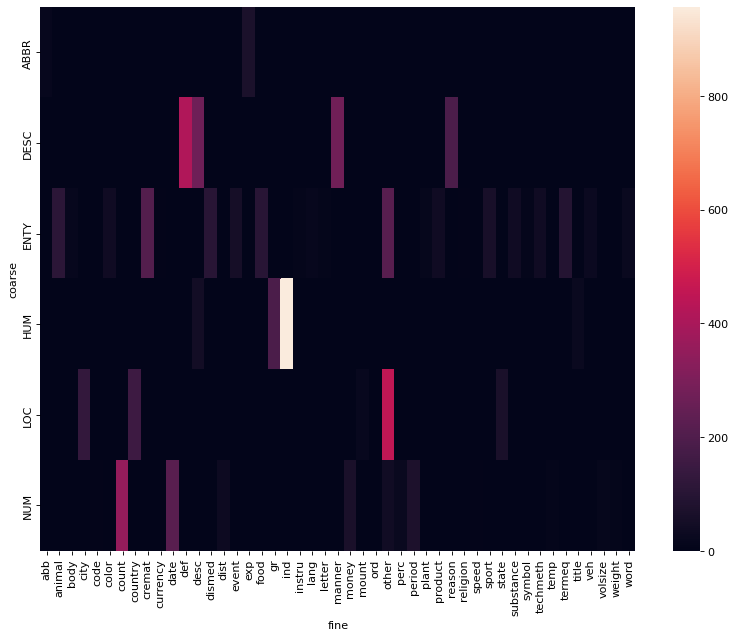

In [ ]:
fig = plt.figure(figsize=(12, 9), dpi=80)
sns.heatmap(crosstb, annot=False)

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramer = cramers_v(df_training.coarse, df_training.fine)


ChiSqResult = ss.chi2_contingency(crosstb)

print(f"Cramer's V: {cramer}", f"Chi Squared Goodness of fit P-Value: {ChiSqResult[1]}")

Cramer's V: 0.9515513620069656 Chi Squared Goodness of fit P-Value: 0.0


#STEP 3: Feature Engineering
Lemmatize the questions to increase performance.

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def lemmatize_question(row):
  lemma_list = nltk.word_tokenize(row.question)
  lemmatized_string = ' '.join([wnl.lemmatize(words) for words in lemma_list])
  return lemmatized_string

df_training['lemma_q'] = df_training.apply(lambda x: lemmatize_question(x), axis =1)
clear_output()

#STEP 4: Training - Dev - Test split


*   To counter imbalance we stratify the sample splitting
*   Despite statification in the test set there are only 46 unique classes for testing

Because of the limitations of the our data we should expect our model performance to be lower than expected especially on minority classes.





Creating training and test. Due to imbalance of dataset we will use stratification to maintain proportion.

In [ ]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
df_train, df_test = train_test_split(
    df_training,
    test_size=test_split,
    stratify=df_training["combined"].values,
    random_state = 0
)

df_train, df_dev = train_test_split(df_train, test_size=0.1, random_state=0,stratify=df_train["combined"].values,)


#df_dev = df_test.sample(frac=0.5, random_state = 0)
#df_test.drop(df_dev.index, inplace=True)

print(f"Number of rows in training set: {len(df_train)}")
print(f"Number of rows in dev set: {len(df_dev)}")
print(f"Number of rows in test set: {len(df_test)}")
print(df_test.coarse.value_counts())
print('Number of unique combined classes in test data:', df_test.combined.nunique())

Number of rows in training set: 4357
Number of rows in dev set: 485
Number of rows in test set: 539
ENTY    124
HUM     122
DESC    116
NUM      85
LOC      83
ABBR      9
Name: coarse, dtype: int64
Number of unique combined classes in test data: 46


#STEP 5: Model Designs



---


## Design 1:
Create model to predict the 'combined' label directly.

> ### Benefits


*   Since fine labels have 47 unique classes and combined labels have 50 unique classes the balance issues are similiar in this training data if you were to pursue design 2
*   This is the easiest model to implement (you only need to train once)

> ### Risks
*   If new data is not similiar to training data the entire model needs to be retrained



---


## Design 2:
Create 2 models to predict the coarse label and fine label independently then combine the results.

> ### Benefits
*   If either coarse or fine label classifiers are inaccurate you can still keep one of the models and retrain the failing classifier

> ### Risks
*   Have to train 2 independent models
*   Fine label classifier still has imbalance issues


---


## Design 3 (Not implemented due to time constraints):
Train the coarse classifier first then feed the results from coarse classifier into the fine label classifier as an additional feature. It is assumed here that coarse classifier would have better performance since it has lower number of classes and better balance of classes in training data.
> ### Benefits
*   Since coarse and fine labels are heavily correlated knowing coarse label may improve performance of the fine label classifier
*  Utilizes more information from training data since coarse label is now an additional feature

> ### Risks
*   The signal from the coarse label might be too strong and result in fine label classifier making predictions only based on coarse label
*   If coarse classifier breaks both models need to be retrained
*   Requires training 2 models

#STEP 6: Basline model - Logistic Regression - Combined label

Logistic regression was chosen as the baseline because it is commonly used in classification tasks, can handle multi-class questions, easy to interpret, and existing [research](https://kavita-ganesan.com/wp-content/uploads/2017/10/stat-segment.pdf) indicates it as a meaningful use of text classification.

In [ ]:
#No lemma logistic model
traing_data = df_train.question
test_data = df_test.question
test_data_labels = df_test.combined
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

log_no_lemma_combined_best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
log_no_lemma_combined_best_classifier.fit(traing_data, df_train.combined)
log_no_lemma_combined_best_predictions = log_no_lemma_combined_best_classifier.predict(test_data)

log_no_lemma_combined_f1_score = metrics.f1_score(df_test.combined, log_no_lemma_combined_best_predictions, average='weighted')
log_no_lemma_combined_baseline_accuracy = np.mean(log_no_lemma_combined_best_predictions == test_data_labels)
log_no_lemma_combined_precision_score = metrics.precision_score(df_test.combined, log_no_lemma_combined_best_predictions, average='macro')
log_no_lemma_combined_recall_score = metrics.recall_score(df_test.combined, log_no_lemma_combined_best_predictions, average='micro')

clear_output()
print('F1:',log_no_lemma_combined_f1_score)
print("Baseline accuracy:", log_no_lemma_combined_baseline_accuracy)
print('Precision:',log_no_lemma_combined_precision_score)
print('Recall:',log_no_lemma_combined_recall_score)

F1: 0.7454221633884754
Baseline accuracy: 0.764378478664193
Precision: 0.6738882749120676
Recall: 0.764378478664193


# STEP 7: Modeling Expirements
Results are at the top of the notebook. There might be variation in metrics because of training runs

# Logistic Regression + lemmas - Combined label

In [ ]:
#lemmatized logistic model
traing_data = df_train.lemma_q
test_data = df_test.lemma_q
test_data_labels = df_test.combined
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_classifier.fit(traing_data, df_train.combined)
best_predictions = best_classifier.predict(test_data)

baseline_accuracy = np.mean(best_predictions == test_data_labels)
precision_score = metrics.precision_score(df_test.combined, best_predictions, average='macro')
recall_score = metrics.recall_score(df_test.combined, best_predictions, average='micro')
f1_score = metrics.f1_score(df_test.combined, best_predictions, average='weighted')
clear_output()
print("Baseline accuracy:", baseline_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

#Logistic Regression + lemmas - coarse and fine labels

In [ ]:
#lemmatized logistic model - coarse
traing_data = df_train.lemma_q
test_data = df_test.lemma_q
test_data_labels = df_test.coarse
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_coarse_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_coarse_classifier.fit(traing_data, df_train.coarse)
best_coarse_predictions = best_coarse_classifier.predict(test_data)

baseline_accuracy = np.mean(best_predictions == test_data_labels)
precision_score = metrics.precision_score(df_test.coarse, best_coarse_predictions, average='macro')
recall_score = metrics.recall_score(df_test.coarse, best_coarse_predictions, average='micro')
f1_score = metrics.f1_score(df_test.coarse, best_coarse_predictions, average='weighted')
clear_output()
print("Baseline accuracy:", baseline_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.0
Precision: 0.8842694533409111
Recall: 0.849721706864564
F1: 0.8511916845274489


In [ ]:
#lemmatized logistic model - fine
traing_data = df_train.lemma_q
test_data = df_test.lemma_q
test_data_labels = df_test.fine
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_fine_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_fine_classifier.fit(traing_data, df_train.fine)
best_fine_predictions = best_fine_classifier.predict(test_data)

baseline_accuracy = np.mean(best_fine_predictions == test_data_labels)
precision_score = metrics.precision_score(df_test.fine, best_fine_predictions, average='macro')
recall_score = metrics.recall_score(df_test.fine, best_fine_predictions, average='micro')
f1_score = metrics.f1_score(df_test.fine, best_fine_predictions, average='weighted')
clear_output()
print("Baseline accuracy:", baseline_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.7699443413729128
Precision: 0.6946409399017327
Recall: 0.7699443413729128
F1: 0.757186136815631


# Deep learning model - BERT Classifier - Combined label

In [ ]:
!pip install transformers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL = "bert-base-uncased"
from transformers import BertTokenizer
clear_output()

In [ ]:
target_names = list(set(df_training.combined.tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'ENTY:other': 0, 'ENTY:food': 1, 'LOC:other': 2, 'LOC:city': 3, 'NUM:weight': 4, 'ENTY:animal': 5, 'ENTY:plant': 6, 'LOC:mount': 7, 'NUM:temp': 8, 'ENTY:dismed': 9, 'ENTY:product': 10, 'ENTY:letter': 11, 'NUM:dist': 12, 'ABBR:exp': 13, 'ABBR:abb': 14, 'ENTY:currency': 15, 'ENTY:event': 16, 'ENTY:termeq': 17, 'NUM:count': 18, 'ENTY:instru': 19, 'DESC:reason': 20, 'ENTY:techmeth': 21, 'HUM:gr': 22, 'ENTY:word': 23, 'NUM:code': 24, 'ENTY:cremat': 25, 'HUM:ind': 26, 'ENTY:body': 27, 'DESC:def': 28, 'ENTY:color': 29, 'DESC:manner': 30, 'DESC:desc': 31, 'HUM:title': 32, 'NUM:date': 33, 'NUM:money': 34, 'LOC:state': 35, 'LOC:country': 36, 'ENTY:veh': 37, 'ENTY:lang': 38, 'NUM:ord': 39, 'NUM:volsize': 40, 'ENTY:religion': 41, 'NUM:period': 42, 'ENTY:substance': 43, 'ENTY:symbol': 44, 'NUM:speed': 45, 'NUM:perc': 46, 'HUM:desc': 47, 'ENTY:sport': 48, 'NUM:other': 49}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
clear_output()

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(df_train.question, df_train.combined, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(df_dev.question, df_dev.combined, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(df_test.question, df_test.combined, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
          #this has changed since the last transformers. So you need to make sure this works. correctly
            model_outputs = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(model_outputs.logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += model_outputs.loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup as WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Loss history: []
Dev loss: 1.0957893588963676


Epoch:   5%|▌         | 1/20 [01:27<27:33, 87.03s/it]

Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Loss history: [1.0957893588963676]
Dev loss: 0.5181282824453186


Epoch:  10%|█         | 2/20 [02:53<26:05, 86.95s/it]

Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [04:19<24:28, 86.35s/it]

Loss history: [1.0957893588963676, 0.5181282824453186]
Dev loss: 0.5546499547712943


Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Loss history: [1.0957893588963676, 0.5181282824453186, 0.5546499547712943]
Dev loss: 0.4961857789689127


Epoch:  20%|██        | 4/20 [05:46<23:04, 86.55s/it]

Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Loss history: [1.0957893588963676, 0.5181282824453186, 0.5546499547712943, 0.4961857789689127]
Dev loss: 0.4347457332427011


Epoch:  25%|██▌       | 5/20 [07:13<21:40, 86.71s/it]

Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch:  30%|███       | 6/20 [08:39<20:08, 86.35s/it]

Loss history: [1.0957893588963676, 0.5181282824453186, 0.5546499547712943, 0.4961857789689127, 0.4347457332427011]
Dev loss: 0.4539244041832931


Training iteration:   0%|          | 0/303 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch:  30%|███       | 6/20 [10:04<23:30, 100.77s/it]

Loss history: [1.0957893588963676, 0.5181282824453186, 0.5546499547712943, 0.4961857789689127, 0.4347457332427011, 0.4539244041832931]
Dev loss: 0.44999249380848866
No improvement on development set. Finish training.


### Evaluation

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)
precision_score = metrics.precision_score(test_correct, test_predicted, average='macro')
recall_score = metrics.recall_score(test_correct, test_predicted, average='micro')
f1_score = metrics.f1_score(test_correct, test_predicted, average='weighted')
clear_output()
print("Baseline accuracy:", bert_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.9107806691449815
Precision: 0.810614323816869
Recall: 0.9107806691449815
F1: 0.9135221552383227


Baseline accuracy: 0.9107806691449815
Precision: 0.810614323816869
Recall: 0.9107806691449815
F1: 0.9135221552383227

# (RUN THIS) Deep learning model - BERT Classifier + lemmas - Combined label

In [ ]:
!pip install transformers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL = "bert-base-uncased"
from transformers import BertTokenizer
clear_output()

In [ ]:
target_names = list(set(df_training.combined.tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
idx2label = {idx: label for idx, label in enumerate(target_names)}
print(idx2label)

{0: 'DESC:def', 1: 'ENTY:techmeth', 2: 'NUM:date', 3: 'HUM:title', 4: 'ENTY:letter', 5: 'ENTY:dismed', 6: 'ENTY:cremat', 7: 'NUM:perc', 8: 'NUM:ord', 9: 'NUM:code', 10: 'LOC:other', 11: 'ENTY:food', 12: 'DESC:manner', 13: 'ENTY:word', 14: 'ENTY:body', 15: 'LOC:city', 16: 'NUM:weight', 17: 'NUM:dist', 18: 'LOC:country', 19: 'ENTY:color', 20: 'NUM:speed', 21: 'ENTY:veh', 22: 'ENTY:instru', 23: 'NUM:volsize', 24: 'ENTY:event', 25: 'NUM:money', 26: 'NUM:other', 27: 'ENTY:animal', 28: 'DESC:reason', 29: 'DESC:desc', 30: 'ENTY:plant', 31: 'HUM:desc', 32: 'LOC:state', 33: 'HUM:ind', 34: 'ABBR:abb', 35: 'ABBR:exp', 36: 'NUM:count', 37: 'ENTY:termeq', 38: 'LOC:mount', 39: 'ENTY:product', 40: 'ENTY:currency', 41: 'ENTY:substance', 42: 'NUM:temp', 43: 'ENTY:lang', 44: 'ENTY:other', 45: 'HUM:gr', 46: 'ENTY:religion', 47: 'ENTY:symbol', 48: 'NUM:period', 49: 'ENTY:sport'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
clear_output()

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(df_train.lemma_q, df_train.combined, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(df_dev.lemma_q, df_dev.combined, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(df_test.lemma_q, df_test.combined, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
          #this has changed since the last transformers. So you need to make sure this works. correctly
            model_outputs = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(model_outputs.logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += model_outputs.loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup as WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: []
Dev loss: 1.074088171605141


Epoch:   5%|▌         | 1/20 [01:23<26:19, 83.15s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: [1.074088171605141]
Dev loss: 0.6255996431554517


Epoch:  10%|█         | 2/20 [02:44<24:40, 82.28s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: [1.074088171605141, 0.6255996431554517]
Dev loss: 0.5552538562445871


Epoch:  15%|█▌        | 3/20 [04:07<23:22, 82.50s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:  20%|██        | 4/20 [05:29<21:55, 82.24s/it]

Loss history: [1.074088171605141, 0.6255996431554517, 0.5552538562445871]
Dev loss: 0.5585194319005935


Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: [1.074088171605141, 0.6255996431554517, 0.5552538562445871, 0.5585194319005935]
Dev loss: 0.5449782212174707


Epoch:  25%|██▌       | 5/20 [06:51<20:31, 82.10s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: [1.074088171605141, 0.6255996431554517, 0.5552538562445871, 0.5585194319005935, 0.5449782212174707]
Dev loss: 0.4579426168854679


Epoch:  30%|███       | 6/20 [08:15<19:17, 82.69s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 7/20 [09:35<17:45, 81.98s/it]

Loss history: [1.074088171605141, 0.6255996431554517, 0.5552538562445871, 0.5585194319005935, 0.5449782212174707, 0.4579426168854679]
Dev loss: 0.46320318001052063


Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 7/20 [10:55<20:18, 93.71s/it]

Loss history: [1.074088171605141, 0.6255996431554517, 0.5552538562445871, 0.5585194319005935, 0.5449782212174707, 0.4579426168854679, 0.46320318001052063]
Dev loss: 0.5027242941150982
No improvement on development set. Finish training.


### Evaluation

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)
precision_score = metrics.precision_score(test_correct, test_predicted, average='macro')
recall_score = metrics.recall_score(test_correct, test_predicted, average='micro')
f1_score = metrics.f1_score(test_correct, test_predicted, average='weighted')
clear_output()
print("Baseline accuracy:", bert_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.9165120593692022
Precision: 0.8963481354151436
Recall: 0.9165120593692022
F1: 0.9159065492458245


In [ ]:
model.save_pretrained('bert_lemma_combined')

# Deep learning model - BERT Classifier + lemmas - Coarse label

In [ ]:
!pip install transformers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL = "bert-base-uncased"
from transformers import BertTokenizer
clear_output()

In [ ]:
target_names = list(set(df_training.coarse.tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
idx2label = {idx: label for idx, label in enumerate(target_names)}
print(idx2label)

{0: 'LOC', 1: 'HUM', 2: 'ENTY', 3: 'DESC', 4: 'ABBR', 5: 'NUM'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
clear_output()

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(df_train.lemma_q, df_train.coarse, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(df_dev.lemma_q, df_dev.coarse, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(df_test.lemma_q, df_test.coarse, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
          #this has changed since the last transformers. So you need to make sure this works. correctly
            model_outputs = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(model_outputs.logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += model_outputs.loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup as WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.22711168746313742


Epoch:   5%|▌         | 1/20 [01:26<27:17, 86.18s/it]

Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [02:47<25:00, 83.33s/it]

Loss history: [0.22711168746313742]
Dev loss: 0.3184694748131498


Training iteration:   0%|          | 0/273 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [04:07<37:10, 123.94s/it]

Loss history: [0.22711168746313742, 0.3184694748131498]
Dev loss: 0.27777382977787524
No improvement on development set. Finish training.


### Evaluation

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)
precision_score = metrics.precision_score(test_correct, test_predicted, average='macro')
recall_score = metrics.recall_score(test_correct, test_predicted, average='micro')
f1_score = metrics.f1_score(test_correct, test_predicted, average='weighted')
clear_output()
print("Baseline accuracy:", bert_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.9406307977736549
Precision: 0.9374130989413381
Recall: 0.9406307977736549
F1: 0.9411313677884153


# Deep learning model - BERT Classifier + lemma - Fine label

In [ ]:
!pip install transformers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_MODEL = "bert-base-uncased"
from transformers import BertTokenizer
clear_output()

In [ ]:
target_names = list(set(df_training.fine.tolist()))
label2idx = {label: idx for idx, label in enumerate(target_names)}
idx2label = {idx: label for idx, label in enumerate(target_names)}
print(idx2label)

{0: 'plant', 1: 'manner', 2: 'country', 3: 'body', 4: 'symbol', 5: 'religion', 6: 'techmeth', 7: 'currency', 8: 'volsize', 9: 'count', 10: 'state', 11: 'reason', 12: 'termeq', 13: 'temp', 14: 'gr', 15: 'date', 16: 'substance', 17: 'period', 18: 'def', 19: 'other', 20: 'ord', 21: 'city', 22: 'money', 23: 'veh', 24: 'desc', 25: 'speed', 26: 'letter', 27: 'mount', 28: 'abb', 29: 'code', 30: 'event', 31: 'instru', 32: 'dismed', 33: 'ind', 34: 'sport', 35: 'lang', 36: 'title', 37: 'color', 38: 'food', 39: 'weight', 40: 'cremat', 41: 'exp', 42: 'dist', 43: 'animal', 44: 'product', 45: 'word', 46: 'perc'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
clear_output()

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(df_train.lemma_q, df_train.fine, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(df_dev.lemma_q, df_dev.fine, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(df_test.lemma_q, df_test.fine, label2idx, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
          #this has changed since the last transformers. So you need to make sure this works. correctly
            model_outputs = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(model_outputs.logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += model_outputs.loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

In [ ]:
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup as WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)

### Evaluation

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)
precision_score = metrics.precision_score(test_correct, test_predicted, average='macro')
recall_score = metrics.recall_score(test_correct, test_predicted, average='micro')
f1_score = metrics.f1_score(test_correct, test_predicted, average='weighted')
clear_output()
print("Baseline accuracy:", bert_accuracy)
print('Precision:',precision_score)
print('Recall:',recall_score)
print('F1:',f1_score)

Baseline accuracy: 0.9035250463821892
Precision: 0.8660022807545011
Recall: 0.9035250463821892
F1: 0.9018427306489025


In [ ]:
model.save_pretrained("bert_lemma_fine")

# STEP 8: Implementation - Design 1 - BERT + Lemmas with Combined Labels

Instruction/setup:

*   Upload training data to colab, place it in the content directory
>*  Make sure that the file is the same format as the training file
*   Make sure to run steps 1 through 6. (This assumes training data format is same as provided train.data.gz file
*   Run STEP 7: Deep learning model - BERT Classifier + lemmas - Combined label - ONLY
>*   Make sure that colab is using GPU setting (Edit -> Notebook Settings)
>*   This will retrain the BERT or train it for the first time if you haven't trained the model before




## Dataloading

Change the file_name variable to the file that you have uploaded.

Also we need to remove duplicates from the test data as well. (This assumption is that our training data is a representation of the actual population)

In [ ]:
import gzip
#change this to the file you want

file_name = 'training.data.gz'
with gzip.open(file_name, mode ='rt',encoding = "ISO-8859-1") as f:
  file_content = f.read()

input_data = []

for row in file_content.split('\n'):
  input_row = {}
  try:
    labels , question = row.split(' ', 1)
    label_1 , label_2 = labels.split(':')
    input_row['coarse'] = label_1
    input_row['fine'] = label_2
    input_row['combined'] = labels
    input_row['question'] = question
    input_data.append(input_row)
  except:
    print(row)
    #there is an extra empty row at the end of the data file


df_data = pd.DataFrame(input_data)

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def lemmatize_question(row):
  lemma_list = nltk.word_tokenize(row.question)
  lemmatized_string = ' '.join([wnl.lemmatize(words) for words in lemma_list])
  return lemmatized_string

df_data['lemma_q'] = df_data.apply(lambda x: lemmatize_question(x), axis =1)
clear_output()
#df_data = df_data[~df_data["question"].duplicated()]
df_data.head()


,coarse,fine,combined,question,lemma_q
0,DESC,manner,DESC:manner,How did serfdom develop in and then leave Russ...,How did serfdom develop in and then leave Russ...
1,ENTY,cremat,ENTY:cremat,What films featured the character Popeye Doyle ?,What film featured the character Popeye Doyle ?
2,DESC,manner,DESC:manner,How can I find a list of celebrities ' real na...,How can I find a list of celebrity ' real name ?
3,ENTY,animal,ENTY:animal,What fowl grabs the spotlight after the Chines...,What fowl grab the spotlight after the Chinese...
4,ABBR,exp,ABBR:exp,What is the full form of .com ?,What is the full form of .com ?


In [ ]:
df_data

,coarse,fine,combined,question,lemma_q
0,DESC,manner,DESC:manner,How did serfdom develop in and then leave Russ...,How did serfdom develop in and then leave Russ...
1,ENTY,cremat,ENTY:cremat,What films featured the character Popeye Doyle ?,What film featured the character Popeye Doyle ?
2,DESC,manner,DESC:manner,How can I find a list of celebrities ' real na...,How can I find a list of celebrity ' real name ?
3,ENTY,animal,ENTY:animal,What fowl grabs the spotlight after the Chines...,What fowl grab the spotlight after the Chinese...
4,ABBR,exp,ABBR:exp,What is the full form of .com ?,What is the full form of .com ?
...,...,...,...,...,...
15447,ENTY,other,ENTY:other,What 's the shape of a camel 's spine ?,What 's the shape of a camel 's spine ?
15448,ENTY,currency,ENTY:currency,What type of currency is used in China ?,What type of currency is used in China ?
15449,NUM,temp,NUM:temp,What is the temperature today ?,What is the temperature today ?
15450,NUM,temp,NUM:temp,What is the temperature for cooking ?,What is the temperature for cooking ?


## Predicting Results

For this implementation you must input the input the lemmatized input questions texts and labels. If there are no golden labels we will feed in a generic response for golden labels that can't be evaluated.

In [ ]:
# 1 == yes, 0 == no
have_true_labels = 1

#put input questions here
input_texts = df_data.lemma_q

if have_true_labels ==1:
  #put golden labels here
  input_true_labels = df_data.combined
else:
  #if there are no golden labels
  input_true_labels = pd.Series(['ENTY:animal' for i in range(len(input_texts))])


features = convert_examples_to_inputs(input_texts, input_true_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
eval_dataloader = get_data_loader(features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
_, true_label_index, predicted_label_index = evaluate(model, eval_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Evaluation iteration:   0%|          | 0/966 [00:00<?, ?it/s]

### Evaluation metrics

In [ ]:

if have_true_labels == 1:
  bert_accuracy = np.mean(predicted_label_index == true_label_index)
  precision_score = metrics.precision_score(true_label_index, predicted_label_index, average='macro')
  recall_score = metrics.recall_score(true_label_index, predicted_label_index, average='micro')
  f1_score = metrics.f1_score(true_label_index, predicted_label_index, average='weighted')
  clear_output()
  print("Bert accuracy:", bert_accuracy)
  print('Precision:',precision_score)
  print('Recall:',recall_score)
  print('F1:',f1_score)
else:
  print('No Golden labels to evaluate')

Bert accuracy: 0.9793554232461817
Precision: 0.956520923947715
Recall: 0.9793554232461817
F1: 0.9788564761714578


### Returning human readable labels

In [ ]:
predicted_labels_data = []
for i in predicted_label_index:
  input_row = {}
  coarse, fine = idx2label[i].split(":")
  input_row['bert_index_label'] = i
  input_row['combined'] = idx2label[i]
  input_row['coarse'] = coarse
  input_row['fine'] = fine
  predicted_labels_data.append(input_row)


df_predicted_results = pd.DataFrame(predicted_labels_data)


df_predicted_results.head()

,bert_index_label,combined,coarse,fine
0,12,DESC:manner,DESC,manner
1,6,ENTY:cremat,ENTY,cremat
2,12,DESC:manner,DESC,manner
3,27,ENTY:animal,ENTY,animal
4,35,ABBR:exp,ABBR,exp


### Save to csv

In [ ]:
df_predicted_results.to_csv("predicted_bert_lemma_combined_results.csv",index=False)

# STEP 9: If no GPU implement logistic regression on new data

Instruction/setup:

*   Upload training data to colab, place it in the content directory
>*  Make sure that the file is the same format as the training file
*   Make sure to run steps 1 through 6. (This assumes training data format is same as provided train.data.gz file
*   Run STEP 7: Logistic Regression + lemmas - coarse and fine labels - ONLY
*  Run STEP 8: Dataloading step
>*   Make sure that colab is using GPU setting (Edit -> Notebook Settings)


Make sure to remove duplicates still

In [ ]:
df_data = df_data[~df_data["question"].duplicated()]

In [ ]:
#lemmatized logistic model - coarse
traing_data = df_train.lemma_q
#make sure to replace the test data with the dataframe that you want
test_data = df_data.lemma_q.fillna('')
test_data_labels = df_data.coarse.fillna('')


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_coarse_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
#fit and predict are here
best_coarse_classifier.fit(traing_data, df_train.coarse)
best_coarse_predictions = best_coarse_classifier.predict(test_data)

coarse_baseline_accuracy = np.mean(best_coarse_predictions == test_data_labels)
coarse_precision_score = metrics.precision_score(df_data.coarse, best_coarse_predictions, average='macro')
coarse_recall_score = metrics.recall_score(df_data.coarse, best_coarse_predictions, average='micro')
coarse_f1_score = metrics.f1_score(df_data.coarse, best_coarse_predictions, average='weighted')
clear_output()
print("Baseline accuracy:", coarse_baseline_accuracy)
print('Precision:',coarse_precision_score)
print('Recall:',coarse_recall_score)
print('F1:',coarse_f1_score)

Baseline accuracy: 0.856
Precision: 0.8868772475636545
Recall: 0.856
F1: 0.8552966479916522


In [ ]:
#lemmatized logistic model - fine
traing_data = df_train.lemma_q


#make sure to replace the test data with the dataframe that you want
test_data = df_data.lemma_q.fillna('')
test_data_labels = df_data.fine.fillna('')



pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_fine_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)

#fit and predict are here
best_fine_classifier.fit(traing_data, df_train.fine)
best_fine_predictions = best_fine_classifier.predict(test_data)

fine_baseline_accuracy = np.mean(best_fine_predictions == test_data_labels)
fine_precision_score = metrics.precision_score(df_data.fine, best_fine_predictions, average='macro')
fine_recall_score = metrics.recall_score(df_data.fine, best_fine_predictions, average='micro')
fine_f1_score = metrics.f1_score(df_data.fine, best_fine_predictions, average='weighted')
clear_output()
print("Baseline accuracy:", fine_baseline_accuracy)
print('Precision:',fine_precision_score)
print('Recall:',fine_recall_score)
print('F1:',fine_f1_score)

Baseline accuracy: 0.782
Precision: 0.7511174292163351
Recall: 0.782
F1: 0.7688642611776518


Outputs

In [ ]:
predicted_labels_data = []

for coarse, fine in zip(best_coarse_predictions, best_fine_predictions,):
  input_row = {}
  input_row['combined'] = coarse + ":" + fine
  input_row['coarse'] = coarse
  input_row['fine'] = fine
  predicted_labels_data.append(input_row)


df_predicted_results = pd.DataFrame(predicted_labels_data)


df_predicted_results.head()

,combined,coarse,fine
0,NUM:dist,NUM,dist
1,LOC:other,LOC,other
2,HUM:ind,HUM,ind
3,DESC:def,DESC,def
4,NUM:date,NUM,date


In [ ]:
df_predicted_results.to_csv("predicted_logistics_lemma_coarse_fine_results.csv",index=False)

# Getting pip requirements

In [ ]:
!pip freeze -> requirements.txt